In [1]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"

In [2]:
## Pdf reader
from langchain_community.document_loaders import PyPDFLoader
loader=PyPDFLoader('blood_pressure_dataset.pdf')
docs=loader.load()

In [3]:
docs

[Document(metadata={'producer': 'Acrobat Distiller 5.00 for Macintosh', 'creator': 'QuarkXPress(tm) 4.11', 'creationdate': '2005-04-19T18:39:48+00:00', 'author': 'NHLBI', 'keywords': 'high blood pressure and children and adolescents, NHLBI, NHBPEP, Diagnosis, Evaluation, and Treatment', 'moddate': '2023-07-18T13:01:26-04:00', 'subject': 'High Blood Pressure', 'title': 'The Fourth Report on the Diagnosis, Evaluation, and Treatment of High Blood Pressure in Children and Adolescents', 'source': 'blood_pressure_dataset.pdf', 'total_pages': 60, 'page': 0, 'page_label': '1'}, page_content='THE FOURTH REPORT ON THE \nDiagnosis, Evaluation, and \nTreatment of High Blood Pressure \nin Children and Adolescents \nU.S. DEPARTMENT OF HEALTH AND HUMAN SERVICES \nNational Institutes of Health \nNational Heart, Lung, and Blood Institute'),
 Document(metadata={'producer': 'Acrobat Distiller 5.00 for Macintosh', 'creator': 'QuarkXPress(tm) 4.11', 'creationdate': '2005-04-19T18:39:48+00:00', 'author': 'N

In [12]:
import langchain_community
import ollama
import numpy as np
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Text splitter to split large documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

# Split the texts into smaller chunks (ensure 'docs' is defined)
split_texts = text_splitter.split_documents(docs)

# Function to embed a document and handle potential errors
def embed_document(doc):
    # If doc is a dictionary, use the text directly
    if isinstance(doc, dict):
        text = doc["page_content"]
    # If doc is a Document object, use its page_content
    else:
        text = doc.page_content
    
    # Get the embeddings response for the text
    embeddings_response = ollama.embeddings(model='nomic-embed-text', prompt=text)
    
    # Debug: check the structure of embeddings_response
    print(f"Embedding response for text '{text[:50]}...': {embeddings_response}")
    
    # Extract the 'embedding' field from the response
    embedding = embeddings_response.get('embedding')
    
    # Ensure the embedding is not empty or malformed
    if not embedding or len(embedding) == 0:
        raise ValueError(f"Empty embedding for text: {text[:50]}...")  # Display a truncated version of text for clarity
    
    # Ensure the embedding is a valid 1D numpy array
    embedding_array = np.array(embedding)
    if embedding_array.ndim != 1 or embedding_array.size == 0:
        raise ValueError(f"Invalid embedding format: {embedding}")
    
    return embedding_array

# Define a wrapper class for the Ollama embedding function
class OllamaEmbeddings:
    def embed_documents(self, texts):
        embeddings = []
        for text in texts:
            try:
                embedding = embed_document({"page_content": text})
                embeddings.append(embedding)
            except ValueError as e:
                print(f"Skipping document due to error: {e}")
        return embeddings

    def embed_query(self, text):
        try:
            embedding = embed_document({"page_content": text})
            return embedding
        except ValueError as e:
            print(f"Skipping query due to error: {e}")
            return None

# Ensure that 'docs' is a list of documents before proceeding (docs should be defined previously)
vector_store = Chroma.from_documents(
    documents=split_texts,
    embedding=OllamaEmbeddings(),
    persist_directory="chroma_db"
)

# Persist the vector store to disk
vector_store.persist()

# Load the vector store from disk
vector_store = Chroma(persist_directory="chroma_db", embedding_function=OllamaEmbeddings())

# Perform a similarity search (ensure 'query' is defined)
results = vector_store.similarity_search(query="Your query text here", k=5)

# Output the results
print("Search results:", results)


Embedding response for text 'THE FOURTH REPORT ON THE 
Diagnosis, Evaluation, a...': embedding=[1.076209545135498, 0.4820723831653595, -3.403642416000366, -0.47604337334632874, 0.3610624074935913, 0.5706571936607361, -0.3357914090156555, 0.3765864670276642, -0.16903246939182281, -0.39342498779296875, 0.04387468099594116, 0.5051360130310059, 0.27651873230934143, -0.8033851385116577, 0.35726043581962585, -1.5806807279586792, -0.5023958086967468, -0.26093238592147827, -0.7464315295219421, -0.4801150858402252, -0.5201988816261292, -0.4240337610244751, -0.9734861850738525, -0.04258869215846062, 1.9140713214874268, 0.7827601432800293, -0.6177392601966858, -0.4341457486152649, -0.36064738035202026, -0.8779627680778503, 0.09967958182096481, -0.41935357451438904, 0.14521418511867523, 0.027855584397912025, -1.005874514579773, -0.5669350028038025, 1.3651546239852905, 0.5075764656066895, -0.3678291141986847, -0.3838958144187927, 0.04410235211253166, -0.24038533866405487, 1.014434814453125, -0.8848

C:\Users\hp\AppData\Local\Temp\ipykernel_16288\99428178.py:74: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_store.persist()
C:\Users\hp\AppData\Local\Temp\ipykernel_16288\99428178.py:77: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(persist_directory="chroma_db", embedding_function=OllamaEmbeddings())


Embedding response for text 'Your query text here...': embedding=[0.6576879620552063, 0.0785900205373764, -3.31132435798645, -0.8468364477157593, 2.038519859313965, -0.983407735824585, 0.7433807253837585, -0.009436579421162605, 0.34343940019607544, -1.4043574333190918, 0.3394847512245178, 1.0977246761322021, 1.1308931112289429, -0.5543294548988342, -1.5115318298339844, -1.3402878046035767, 0.8531128168106079, -0.9154517650604248, 0.5810323357582092, 1.5701801776885986, -1.306095004081726, -0.24904049932956696, -1.4902801513671875, -0.03838097304105759, 2.411442756652832, -0.3640264868736267, -0.895218551158905, 0.2938331067562103, -1.2860318422317505, 0.0772913470864296, 0.04350599646568298, 0.3800818622112274, -0.3727869987487793, -0.25785499811172485, -1.0561283826828003, 0.30196094512939453, -0.09451602399349213, 0.2861667275428772, -0.6655166149139404, 1.2034306526184082, 1.9221420288085938, -0.9666319489479065, -0.1567528247833252, -1.4818636178970337, 0.9537892937660217, -0.35533

In [13]:
query = "What is the relationship between blood pressure and heart disease?"
results = vector_store.similarity_search(query, k=3)
# Display the results
for result in results:
    print(f"Document: {result.metadata['source']}")
    print(f"Content: {result.page_content}\n")

Embedding response for text 'What is the relationship between blood pressure an...': embedding=[1.8799159526824951, 0.9669566750526428, -3.6365935802459717, 0.8532373309135437, 0.7076244950294495, 0.656515896320343, -0.6223564147949219, -0.019998537376523018, 0.593794584274292, -1.652174949645996, 0.827880322933197, 2.232396364212036, 0.32038506865501404, -0.4132431745529175, 0.7093736529350281, -0.4759611189365387, -0.9088401198387146, 0.013924735598266125, -0.4217780530452728, -0.07228371500968933, -0.9734303951263428, 0.5489157438278198, -0.6753426790237427, -0.07225008308887482, 0.9526532292366028, 0.7713429927825928, -0.6882361173629761, 0.25284895300865173, -1.194698691368103, 0.19200552999973297, 1.3430222272872925, -0.3027053773403168, 1.1246347427368164, -0.6957239508628845, -1.0494335889816284, -1.0700873136520386, 1.0170522928237915, 1.1916923522949219, 1.5777242183685303, 0.4869593381881714, 0.5796957612037659, -1.0562448501586914, 0.6272690296173096, -1.0628496408462524, -

In [14]:
from langchain_community.llms import Ollama
llm = Ollama(model="deepseek-r1:7b")
from langchain.chains import RetrievalQA
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

C:\Users\hp\AppData\Local\Temp\ipykernel_16288\4008349988.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="deepseek-r1:7b")


In [15]:
# Run the QA chain with a query
query = "What is the relationship between blood pressure and heart disease?"
result = qa_chain({"query": query})
# Display the result
print(f"Query: {query}")
print(f"Answer: {result['result']}")
print("Source Documents:")
for doc in result['source_documents']:
    print(f"Document: {doc.metadata['source']}")
    print(f"Content: {doc.page_content}\n")

C:\Users\hp\AppData\Local\Temp\ipykernel_16288\287401128.py:3: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": query})


Embedding response for text 'What is the relationship between blood pressure an...': embedding=[1.8799159526824951, 0.9669566750526428, -3.6365935802459717, 0.8532373309135437, 0.7076244950294495, 0.656515896320343, -0.6223564147949219, -0.019998537376523018, 0.593794584274292, -1.652174949645996, 0.827880322933197, 2.232396364212036, 0.32038506865501404, -0.4132431745529175, 0.7093736529350281, -0.4759611189365387, -0.9088401198387146, 0.013924735598266125, -0.4217780530452728, -0.07228371500968933, -0.9734303951263428, 0.5489157438278198, -0.6753426790237427, -0.07225008308887482, 0.9526532292366028, 0.7713429927825928, -0.6882361173629761, 0.25284895300865173, -1.194698691368103, 0.19200552999973297, 1.3430222272872925, -0.3027053773403168, 1.1246347427368164, -0.6957239508628845, -1.0494335889816284, -1.0700873136520386, 1.0170522928237915, 1.1916923522949219, 1.5777242183685303, 0.4869593381881714, 0.5796957612037659, -1.0562448501586914, 0.6272690296173096, -1.0628496408462524, -

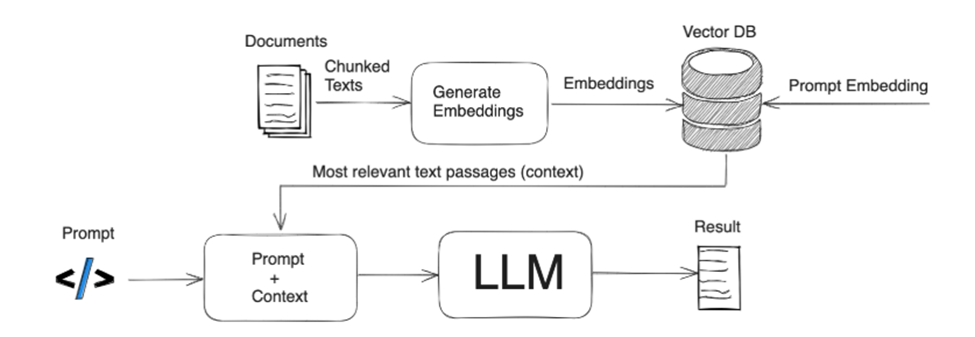